Projektina suoritetaan samanaikaisesti mitattujen GPS- ja kiihtyvyyshavaintojen analyysi ja tuotetaan siitä laadukas visualisointi.  Työn tuloksena syntyy eräänlainen urheilusovelluksen prototyyppi, jonka avulla voi esimerkiksi analysoida mitattua liikettä harjoittelun ajalta. 
Mittaukset

Kävele ulkona vähintään muutaman minuutin ajan ja mittaa samalla kiihtyvyyttä ja sijaintia Phyphox-sovelluksella. Pidä puhelin koko ajan samassa asennossa, mielellään melko lähellä ylävartaloa. 

Sinun tulee tässä mitata kahta suuretta samanaikaisesti:

- Valitse Phyhoxista plus-symboli oikeasta alanurkasta
- Valitse "Add simple experiment"
- Valitse sensorit "Linear Acceleration" ja "Location"
- Paina ok, käynnistä mittaus aukeavassa "My experiment" -ikkunassa kun olet valmis aloittamaan mittauksen. 

Mittauksen aikana kannattaa vilkuilla Location-välilehteä. GPS-signaalin löytymisessä kestää aikansa. Voit myös pysyä ensin paikallasi ja lähteä liikkumaan vasta, kun GPS-signaali näyttää löytyneen. Voit sitten myöhemmin poistaa molemmista datoista alkupätkän, jonka aikana et liikkunut. 

Mittaus toimii kuten ennenkin, mutta tuottaa nyt kaksi csv-tiedosto (Accelerometer.csv ja Location.csv).

Jos olet estynyt liikkumaan ulkotilassa, ole yhteydessä opettajaan. 
Analyysi ja visualisointi

Tutki, missä kiihtyvyyden komponentissa kävelyliike havaitaan parhaiten, valitse se analyysiin kiihtyvyyden osalta.

Määrittele havainnoista kurssilla oppimasi perusteella seuraavat asiat ja esitä ne numeroina visualisoinnissasi:

- Askelmäärä laskettuna suodatetusta kiihtyvyysdatasta

- Askelmäärä laskettuna kiihtyvyysdatasta Fourier-analyysin perusteella

- Keskinopeus (GPS-datasta)

- Kuljettu matka (GPS-datasta)

- Askelpituus (lasketun askelmäärän ja matkan perusteella)

Esitä seuraavat kuvaajat

- Suodatettu kiihtyvyysdata, jota käytit askelmäärän määrittelemiseen. 

- Analyysiin valitun kiihtyvyysdatan komponentin tehospektritiheys

- Reittisi kartalla

------------------------------------

Aloitetaan siitä, että tuodaan kiihtyvyysdata sisään ja rajataan sitä, jotta saamme valittua sopivan anturin tuottaman datan. 

Mittasin datan erehdyksessä käyttäen Acceleration -mittausta Linear Accelerationin sijaan, joten sillä mennään.

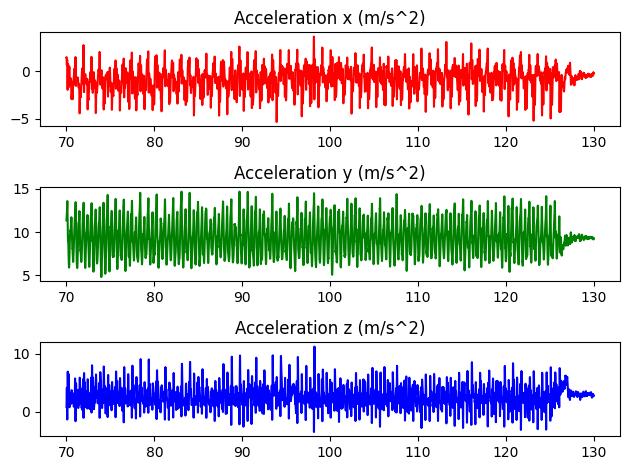

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('Acc.csv')

# Suodatetaan datan neljän minuutin mittaustulos aikavälille 70-130 sekuntia, 
# jotta näemme mikä anturi on käyttökelpoisin
df1_filtered = df1[(df1['Time (s)'] >= 70) & (df1['Time (s)'] <= 130)]

# Piirretään suodatettu data
plt.subplot(3,1,1)
plt.plot(df1_filtered['Time (s)'], df1_filtered['Acceleration x (m/s^2)'], color='r')
plt.title('Acceleration x (m/s^2)')
plt.subplot(3,1,2)
plt.plot(df1_filtered['Time (s)'], df1_filtered['Acceleration y (m/s^2)'], color='g')
plt.title('Acceleration y (m/s^2)')
plt.subplot(3,1,3)
plt.plot(df1_filtered['Time (s)'], df1_filtered['Acceleration z (m/s^2)'], color='b')
plt.title('Acceleration z (m/s^2)')

plt.tight_layout()
plt.show()

Kuvaajat ovat varsin selkeitä, mutta se mikä pistää parhaiten silmää on kuvaaja x:n tasaisuus y-akselin nollan pinnassa. Se näyttäisi siis olevan käppyröistä se, josta on helpointa laskea askelmäärä nollaylitysten osalta. Pidin kyllä puhelinta jatkuvasti kädessä ja lähellä ylävartaloani, mutta jostain syystä y-akselin data on jatkuvasti välillä 5-15.

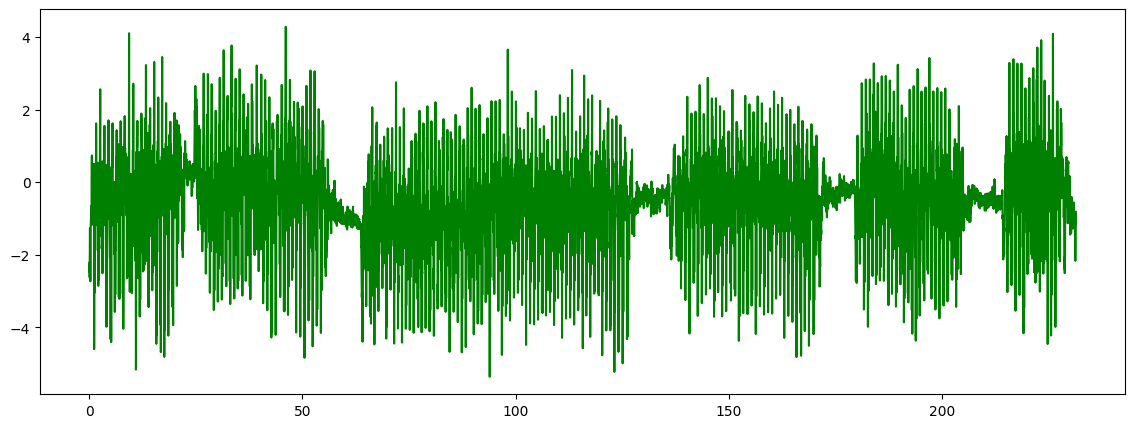

In [2]:
#Valitaan tarkasteltavaksi kuvaaja x ja tehdään siitä kuvaaja tarkasteltavaksi
plt.figure(figsize=(14, 5))
plt.plot(df1['Time (s)'], df1['Acceleration x (m/s^2)'], color='g')

Kiihtyvysdatassa on pysäytyksiä, koska se tallennettiin koiraa ulkoiluttaessa. Päätämme, että emme anna sen häiritä.

(np.float64(0.0), np.float64(20.0), np.float64(-6.0), np.float64(5.0))

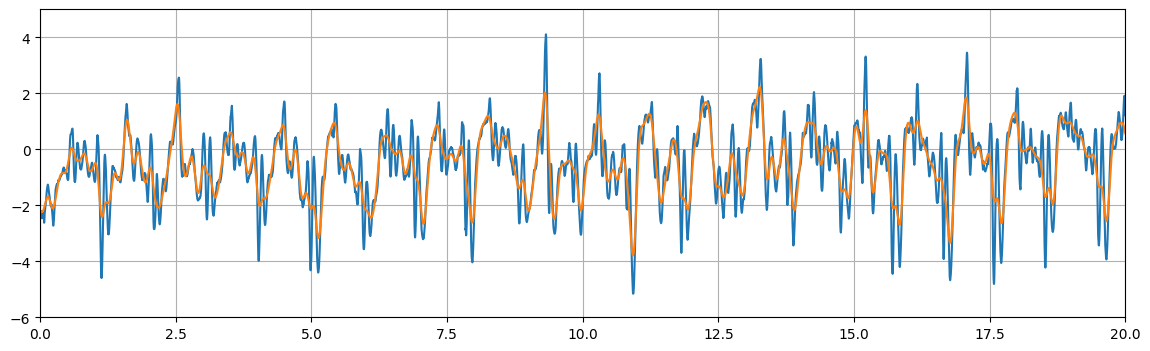

In [3]:
#Suodatetaan datasta selvästi kävelytaajuutta suurempitaajuuksiset vaihtelut pois
#filtteri:
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, nyq, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

#Filtereiden parametrit:
T = df1['Time (s)'][len(df1['Time (s)'])-1] - df1['Time (s)'][0]
n = len(df1['Time (s)']) #Datapisteiden lukumäärä
fs = n/T #Näytteenotto (olettaen jotakuinkin vakioksi)
nyq = fs/2 #Nyqvistin taajuus
order = 3 #Kertaluku
cutoff = 1/(0.2) #Cutoff taajuus

filtered_signal = butter_lowpass_filter(df1['Acceleration x (m/s^2)'], cutoff, nyq, order)

plt.figure(figsize=(14,4))
plt.plot(df1['Time (s)'], df1['Acceleration x (m/s^2)'])
plt.plot(df1['Time (s)'], filtered_signal)
plt.grid()

#Tulostetaan selkeyden vuoksi näkyville x-akselin raja-arvot 0-20 ja y-akselin -6,5
plt.axis([0,20,-6,5])

Kyllähän tästä näkee, että datasta suodattui terävin sotku pois. Lähdetään siis laskemaan tästä suodatetusta datasta askelmäärä.

In [4]:
import numpy as np

#Lasketaan jaksojen määrä signaalissa (ja sitä kautta askelten määrä) 
#laskemalla signaalin nollakohtien ylitysten määrä. 
#Nolla ylitetään kaksi kertaa jokaisen jakson aikana
jaksot = 0
for i in range(len(filtered_signal)-1):
    if filtered_signal[i]/filtered_signal[i+1] < 0:
        jaksot = jaksot +1
print('Askelmäärä suodatetun datan perusteella on ', np.floor(jaksot/2))

Askelmäärä suodatetun datan perusteella on  286.0


Askelmäärä vaikuttaa edellisiin kurssilla tehtyihin tehtäviin verraten varsin korkea, mutta se johtuu siitä, että nauhoitin dataa hyvin pitkän (jopa neljän minuutin ajan). 

Jatketaan tästä Fourier-analyysin pariin ja lasketaan askelmäärä sitä käyttäen.

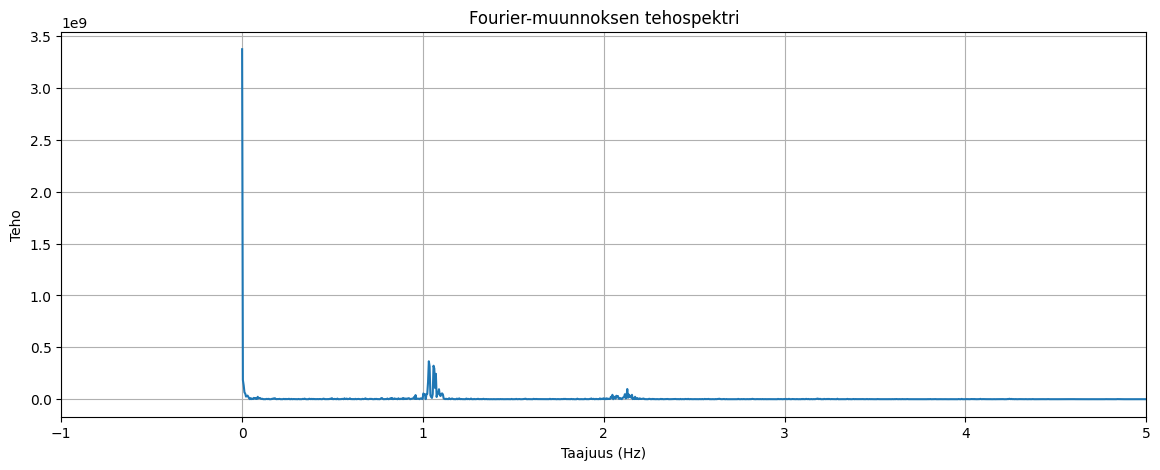

In [5]:
from scipy.fft import fft, fftfreq

# Näytteenottotaajuus
T = df1['Time (s)'][1] - df1['Time (s)'][0]  # Oletetaan vakio näytteenottoväli
N = len(filtered_signal)
fs = 1 / T

# Fourier-muunnos
yf = fft(filtered_signal)
xf = fftfreq(N, T)[:N//2]

# Laske tehospektri
power_spectrum = np.abs(yf[:N//2])**2

# Piirretään tehospektri
plt.figure(figsize=(14, 5))
plt.plot(xf, power_spectrum)
plt.grid()
plt.title('Fourier-muunnoksen tehospektri')
plt.xlabel('Taajuus (Hz)')
plt.ylabel('Teho')
plt.xlim(-1, 5)
plt.show()



In [6]:
# Etsitään huippu Fourier-spektristä
peak_freq = xf[np.argmax(2.0/N * np.abs(yf[:N//2][1:])) + 1]

# Lasketaan askelmäärä
total_time = df1['Time (s)'].iloc[-1] - df1['Time (s)'].iloc[0]
steps = peak_freq * total_time

print('Askelmäärä Fourier-analyysin perusteella on ', np.floor(steps))

Askelmäärä Fourier-analyysin perusteella on  238.0


Lopputuloksen perusteella voidaan päätellä, että Fourier-analyysin avulla tehdyssä suodatuksessa lopullisesta askelmäärästä häviää jonkin verran askelia. Tämä oli toki jo ennakkoon tiedossa, joten lopputuloksen 48 askeleen heittoa (alkuperäisen datan pysähtymisineen) on pidettävä ihan kelvollisena lopputuloksena.

Jatketaan lopputyön seuraavan osion pariin, eli pureudutaan kiihtyvyyden kanssa yhtä aikaa mitattuun GPS-dataan. 

In [7]:
#Piirretään tässä kartta saadusta datasta
import folium

df2 = pd.read_csv('GPS.csv')

df2_orig = df2.copy()

#Määritellään kartan keskipiste ja laajuus (mittakaava, zoomaus)
#Keskipiste on loogisesti mahdollisimman keskellä liikuttua reittiä 
lat_mean = df2['Latitude (°)'].mean()
long_mean = df2['Longitude (°)'].mean()

#luodaan kartta
my_map = folium.Map(location = [lat_mean, long_mean], zoom_start = 18)

#Piirretään reitti
folium.PolyLine(df2[['Latitude (°)', 'Longitude (°)']], color = 'blue', opacity = 1).add_to(my_map)

#Tallennetaan kartta
my_map.save('Kartta_08102024.html')
my_map

Siinähän se nyt sitten on. Kuljetussa reirissä näkyy pyörätie jota kuljimme koirani kanssa ja myös useat harhailut tien ulkopuolelle, mikä selittyy koiran haistelutarpeilla. Alussa (kuljetun reitin oikeanpuoleinen pääty) näkyy erikoinen pystyviiva, joka tarkoittanee hetkeä jolloin GPS haki vielä yhteyttä. 

Lasketaan GPS datasta keskinopeus ja sitten kuljettu matka.

In [8]:
#Suodatetaan pois puuttuvat arvot
df2_filtered = df2.dropna(subset=['Velocity (m/s)'])

#Lasketaan keskinopeus
average_velocity = df2_filtered['Velocity (m/s)'].mean()
print('Keskinopeus on', average_velocity, 'm/s')

Keskinopeus on 1.2558329087348683 m/s


In [9]:
#Lasketaan aikavälit
time_diffs = df2_filtered['Time (s)'].diff().fillna(0)

#Lasketaan matkat
distances = df2_filtered['Velocity (m/s)'] * time_diffs

#Summataan matkat
total_distance = distances.sum()
print('Kuljettu matka on', total_distance, 'metriä')

Kuljettu matka on 286.03995362912303 metriä


Pidän tätä tulosta hyvin uskottavana, sillä koiran kanssa ulkoillessa astelen pidempiä askelia (koira vetää hieman) ja olen muutenkin vauhdikas kävelijä, joten aiemman 286 askeleen tuloksen perusteella astun aika tarkalleen 1 metrin pituisia askelia näissä olosuhteissa.

Vaikka tässä tulikin jo todettua arvio askelpituudesta, niin tuotetaan tämä toteamus myös laskennallisesti. 

In [10]:
#Lasketaan askelpituus
step_length = total_distance / steps
print('Askelpituus on', step_length, 'metriä')

Askelpituus on 1.197200998087801 metriä


Hieman päälle metrin askellus siis. Melkoista harppausta. Pikainen googletus tuottaa tuloksen, että miehen keskimääräinen askellus on 75cm, joten ainakin koiraa ulkoiluttaessa astelen itse metrin kerrallaan. Pidän tätä ihan todennäköisenä tuloksena, sillä kuten aiemmin mainitsin, olen aina ollut hyvin nopea ja harppova kävelijä.

Siinäpä tämän kurssin fysiikan osuuden lopputyö. Toivottavasti tämä nyt meni nappiin, uskoisin ainakin näin.

Tulostan tähän alle vielä lopputyön summauksen.

# Fysiikan lopputyö - Summaus


In [17]:
print(f'Askelmäärä suodatetun datan perusteella on {np.floor(jaksot/2):.0f} askelta.')
print(f'\nAskelmäärä Fourier-analyysin perusteella on {np.floor(steps):.0f} askelta.')
print(f'\nKeskinopeus on {average_velocity:.1f} m/s')
print(f'\nKuljettu kokonaismatka on {total_distance:.2f} metriä')
print(f'\nAskelpituus on {step_length:.1f} metriä')

Askelmäärä suodatetun datan perusteella on 286 askelta.

Askelmäärä Fourier-analyysin perusteella on 238 askelta.

Keskinopeus on 1.3 m/s

Kuljettu kokonaismatka on 286.04 metriä

Askelpituus on 1.2 metriä


# Suodatetun kiihtyvyysdatan y-komponentti

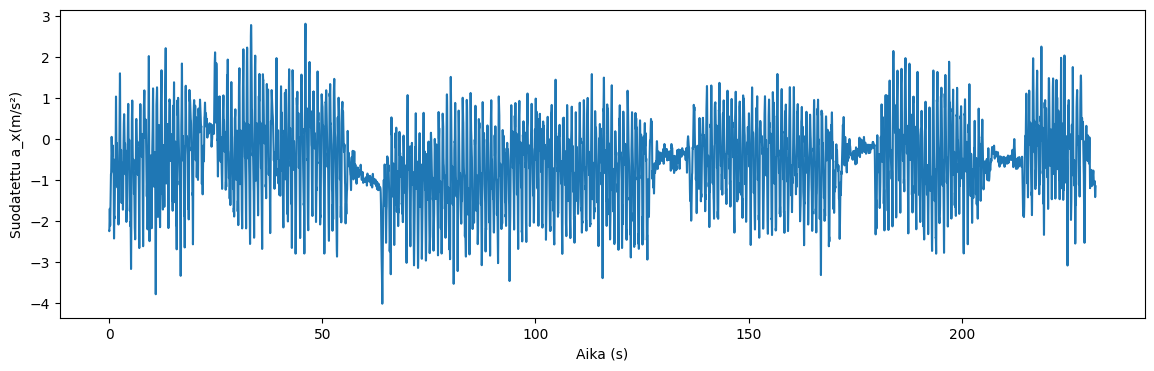

In [12]:
plt.figure(figsize=(14,4))
plt.plot(df1['Time (s)'], filtered_signal)
plt.xlabel('Aika (s)')
plt.ylabel('Suodatettu a_x(m/s²)')
plt.show()

# Tehospektri

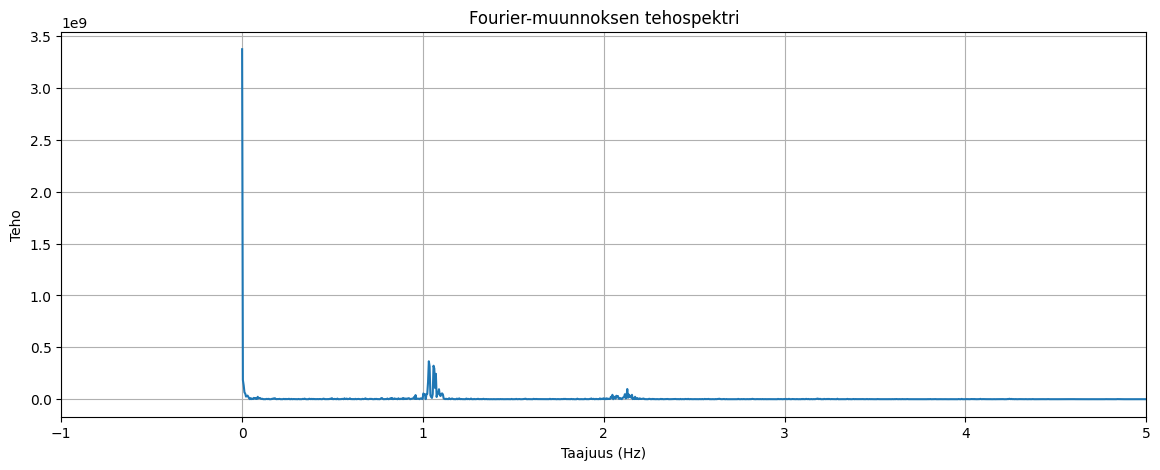

In [13]:
plt.figure(figsize=(14, 5))
plt.plot(xf, power_spectrum)
plt.grid()
plt.title('Fourier-muunnoksen tehospektri')
plt.xlabel('Taajuus (Hz)')
plt.ylabel('Teho')
plt.xlim(-1, 5)
plt.show()

# Karttakuva

![Kartta](kartta.png)